## Comparative analysis of network attack prediction using machine learning and deep learning approaches

## Problem Statement

Cyber-adversaries are becoming more sophisticated in their efforts to avoid detection, and many modern malware tools are already incorporating new ways to bypass antivirus and other threat detection measures. Software to detect network attacks protects a computer network from unauthorized users, including perhaps insiders. We need new methods to find out the attacks.
This is a multi-class classification problem. The given dataset contains 41 feature columns and 1 label column. The task is to classify the data into 5 types of network attacks, namely:-
<br /><br />

ipsweep probe <br />
back dos <br />
satan probe <br />
portsweep probe <br />
normal<br />

<b>ipsweep attack</b>: IP sweep also known as ICMP sweep attack occurs when the attacker sends ICMP(Internet Control Message Protocol) echo requests to multiple destination addresses. If a target host replies to these requests, the reply reveals the targets IP address to the attacker. IP sweep is aimed at determining which range of IP addresses map to live hosts. <br /> <br />

<b>satan probe</b>: SATAN is a historical vulnerability scanner that was developed in the 1990s by Dan Farmer and Wietse Venema. It was designed to assess the security of networked systems by scanning for known vulnerabilities and misconfigurations. SATAN provided a web-based interface to display the results of its scans and offered recommendations for remediation.<br /> <br />

<b>portsweep probe</b>: A portsweep attack is a network reconnaissance technique used by malicious actors to scan a range of network ports on multiple target systems. The objective is to identify which ports are open and potentially vulnerable to exploitation.<br /> <br />


## Processing the input

In [28]:
import pandas as pd
import numpy as np

# Visualisation libraries
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# For Garbage collection
import gc

# For hyperparam tuning
from sklearn.model_selection import GridSearchCV

# Data preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Classification report
from sklearn.metrics import classification_report

# Tensorflow and Keras
from keras.models import Sequential
from keras.layers import Dense
#For early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Reading the input

input_df = pd.read_csv("train.csv")
input_df.head()

,Id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,1,0,tcp,other,REJ,0,0,0,0,0,...,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00,satan.
1,2,0,tcp,http,SF,54540,8314,0,0,0,...,178,1.0,0.0,0.01,0.00,0.00,0.0,0.01,0.01,back.
2,3,0,tcp,other,REJ,0,0,0,0,0,...,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00,satan.
3,4,0,icmp,eco_i,SF,8,0,0,0,0,...,86,1.0,0.0,1.00,0.51,0.00,0.0,0.00,0.00,ipsweep.
4,5,0,tcp,other,REJ,0,0,0,0,0,...,1,0.0,1.0,0.00,0.00,0.07,0.0,0.93,1.00,satan.


In [6]:
#Reading the test dataset
X_test = pd.read_csv("test.csv")

## Exploratory Data Analysis

In [19]:
input_df.shape

(12989, 43)

In [20]:
input_df.columns

Index(['Id', 'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'type_of_attack'],
      dtype='object')

In [21]:
input_df.dtypes

Id                               int64
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate              

### Distribution of target variable

In [22]:
target_distrib = input_df['type_of_attack'].value_counts()
target_distrib

ipsweep.      5318
satan.        3711
portsweep.    1999
back.         1400
normal.        561
Name: type_of_attack, dtype: int64

In [23]:
labels = target_distrib.index
values = list(target_distrib)

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

### Distribution of other categorical variables

In [24]:
input_df["protocol_type"].value_counts()

tcp     8052
icmp    4665
udp      272
Name: protocol_type, dtype: int64

In [25]:
input_df["service"].value_counts() 

eco_i        4663
other        3400
private      2592
http         1971
ftp_data       33
             ... 
efs             1
pop_3           1
http_443        1
http_2784       1
iso_tsap        1
Name: service, Length: 61, dtype: int64

In [26]:
input_df["flag"].value_counts()  

SF        6925
REJ       3831
RSTR      1793
S0         317
RSTOS0      76
RSTO        36
OTH          5
S2           4
S1           2
Name: flag, dtype: int64

In [27]:
for col in input_df.columns:
    print(input_df[col].value_counts())

1        1
8664     1
8654     1
8655     1
8656     1
        ..
4334     1
4335     1
4336     1
4337     1
12989    1
Name: Id, Length: 12989, dtype: int64
0     12710
1       133
6        32
5        20
25       12
27       12
2        10
4         6
10        5
7         5
21        4
8         4
13        3
24        3
15        3
17        3
28        3
22        3
3         3
20        2
29        2
14        2
23        2
19        2
9         1
78        1
12        1
60        1
11        1
Name: duration, dtype: int64
tcp     8052
icmp    4665
udp      272
Name: protocol_type, dtype: int64
eco_i        4663
other        3400
private      2592
http         1971
ftp_data       33
             ... 
efs             1
pop_3           1
http_443        1
http_2784       1
iso_tsap        1
Name: service, Length: 61, dtype: int64
SF        6925
REJ       3831
RSTR      1793
S0         317
RSTOS0      76
RSTO        36
OTH          5
S2           4
S1           2
Name: flag, dtype:

### Checking for null values

In [28]:
input_df.isnull().sum()

Id                             0
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_r

In [29]:
input_df.columns

Index(['Id', 'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'type_of_attack'],
      dtype='object')

In [32]:
distrib = pd.crosstab(input_df['protocol_type'], input_df['type_of_attack'])
distrib

type_of_attack,back.,ipsweep.,normal.,portsweep.,satan.
protocol_type,,,,,
icmp,0,4654,0,0,11
tcp,1400,664,561,1999,3428
udp,0,0,0,0,272


In [33]:
distrib.index, distrib.values

(CategoricalIndex(['icmp', 'tcp', 'udp'], categories=['icmp', 'tcp', 'udp'], ordered=False, dtype='category', name='protocol_type'),
 array([[   0, 4654,    0,    0,   11],
        [1400,  664,  561, 1999, 3428],
        [   0,    0,    0,    0,  272]]))

## Data pre processing

Dropping the Id columns

In [7]:
input_df.drop(columns=['Id'], inplace=True)
X_test.drop(columns=['Id'], inplace=True)

In [8]:
X = input_df.drop(columns=["type_of_attack"])
Y = input_df["type_of_attack"]

In [9]:
#Converting object dtypes to category
cat_attr=X.select_dtypes(include ='object').columns
X[cat_attr] = X[cat_attr].astype('category')

In [10]:
#Applying one hot encoding on the categorical attributes
X = pd.get_dummies(columns=cat_attr, data = X, prefix=cat_attr, prefix_sep="_", drop_first=True)

In [11]:
X_test = pd.get_dummies(columns=cat_attr, data = X_test, prefix=cat_attr, prefix_sep="_", drop_first=True) 

In [12]:
# Checking for mismatching columns
test_cols = set(X_test.columns)
train_cols = set(X.columns)

missing_cols_train = train_cols - test_cols

print(len(missing_cols_train))

for col in missing_cols_train:
    X_test[col] = 0


# To maintain consistency in the order of columns
X_test = X_test[X.columns]

13


Dropping zero variance and constant values categorical columns

In [13]:
print("Number of numerical columns before zero variance thresholding: {}".format(len(X.columns)))

# Applying variance thresholding on the numerical columns
selector = VarianceThreshold(0.1)
filtered_data = selector.fit_transform(X)

# Get selected numerical column names
selected_numerical_cols = X.columns[selector.get_support()]
# Create dataframe with selected numerical columns
X = pd.DataFrame(filtered_data, columns=selected_numerical_cols)
print("Number of numerical columns after zero variance thresholding: {}".format(len(selected_numerical_cols)))

Number of numerical columns before zero variance thresholding: 108
Number of numerical columns after zero variance thresholding: 27


In [14]:
X_test = X_test[selected_numerical_cols]

Final shape after dropping the columns

In [15]:
X.shape

(12989, 27)

In [16]:
X_test.shape

(5567, 27)

In [17]:
#Label encoding target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [19]:
X_train.shape, X_val.shape

((9092, 27), (3897, 27))

## Machine learning models

### Machine learning models util

In [18]:
def perform_grid_search(model, param_grid, cv=5):
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)

    # Get the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    return best_model, best_params

In [19]:
def classification_report_on_train_and_val(model, X_train, y_train, X_val, y_val, X_test):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    print("Classification report on train dataset: ")
    print(classification_report(y_train, y_train_pred, target_names=["ipsweep.","satan.", "portsweep.", "back.", "normal."]))
    print("Classification report on validation dataset: ")
    print(classification_report(y_val, y_val_pred, target_names=["ipsweep.","satan.", "portsweep.", "back.", "normal."]))
    return y_test_pred

### Logistic Regression

In [20]:
# Define the Logistic Regression model
model = LogisticRegression(random_state=0, class_weight='balanced', multi_class='ovr', solver='liblinear')

# Define the hyperparameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0]
}

best_model, best_params = perform_grid_search(model, param_grid)
print(best_params)
y_pred_LR = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'C': 1.0, 'penalty': 'l1'}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       1.00      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       0.99      1.00      1.00       168
       back.       1.00      1.00      1.00       600
     normal.       1.00      1.00      1.00      1113

    accuracy                           1.00      3897
   macro avg    

### SVM Classifier

In [21]:
svm_model = SVC(class_weight='balanced')
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}

best_model, best_params = perform_grid_search(svm_model, param_grid)
print(best_params)
y_pred_SVC = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'C': 1, 'kernel': 'linear'}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       1.00      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       1.00      1.00      1.00       168
       back.       1.00      1.00      1.00       600
     normal.       1.00      1.00      1.00      1113

    accuracy                           1.00      3897
   macro avg   

### Decision Tree Classifier

In [22]:
tree_model = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': [None, 5, 10], 'criterion': ['gini', 'entropy']}

best_model, best_params = perform_grid_search(tree_model, param_grid)
print(best_params)
y_pred_dt = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'criterion': 'gini', 'max_depth': 5}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       0.99      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       1.00      1.00      1.00       168
       back.       1.00      1.00      1.00       600
     normal.       1.00      1.00      1.00      1113

    accuracy                           1.00      3897
   mac

### Random Forest Classifier

In [23]:
rf_model = RandomForestClassifier(oob_score=True, class_weight='balanced')
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}

best_model, best_params = perform_grid_search(rf_model, param_grid)
print(best_params)
y_pred_rf = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'max_depth': None, 'n_estimators': 100}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       1.00      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       1.00      1.00      1.00       168
       back.       1.00      1.00      1.00       600
     normal.       1.00      1.00      1.00      1113

    accuracy                           1.00      3897
   

In [44]:
y_pred = best_model.predict_proba(X_val)
y_pred.shape

(3897, 5)

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred,multi_class='ovo')

0.9999998502545673

In [24]:
# Out of bag accuracy
best_model.oob_score_

0.9997800263968324

### XGBoost Classifier

In [27]:
xgb_model = xgb.XGBClassifier()
param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}

best_model, best_params = perform_grid_search(xgb_model, param_grid)
print(best_params)
y_pred_xgb = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'learning_rate': 0.1, 'max_depth': 3}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       1.00      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       1.00      1.00      1.00       168
       back.       1.00      1.00      1.00       600
     normal.       1.00      1.00      1.00      1113

    accuracy                           1.00      3897
   ma

### KNN Classifier

In [26]:
knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

best_model, best_params = perform_grid_search(knn_model, param_grid)
print(best_params)
y_pred_knn = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'n_neighbors': 3, 'weights': 'distance'}
Classification report on train dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       980
      satan.       1.00      1.00      1.00      3722
  portsweep.       1.00      1.00      1.00       393
       back.       1.00      1.00      1.00      1399
     normal.       1.00      1.00      1.00      2598

    accuracy                           1.00      9092
   macro avg       1.00      1.00      1.00      9092
weighted avg       1.00      1.00      1.00      9092

Classification report on validation dataset: 
              precision    recall  f1-score   support

    ipsweep.       1.00      1.00      1.00       420
      satan.       1.00      1.00      1.00      1596
  portsweep.       0.99      1.00      0.99       168
       back.       0.98      0.96      0.97       600
     normal.       0.98      0.99      0.99      1113

    accuracy                           0.99      3897
  

### Building an Artificial Neural Network

In [36]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                896       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,509
Trainable params: 1,509
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Train the model
hist = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
285/285 [==============================] - 1s 1ms/step - loss: 30.1595 - accuracy: 0.8211 - val_loss: 0.2827 - val_accuracy: 0.9307
Epoch 2/15
285/285 [==============================] - 0s 543us/step - loss: 0.1577 - accuracy: 0.9579 - val_loss: 0.1469 - val_accuracy: 0.9674
Epoch 3/15
285/285 [==============================] - 0s 537us/step - loss: 0.1158 - accuracy: 0.9743 - val_loss: 0.1093 - val_accuracy: 0.9743
Epoch 4/15
285/285 [==============================] - 0s 545us/step - loss: 0.0667 - accuracy: 0.9816 - val_loss: 0.0899 - val_accuracy: 0.9746
Epoch 5/15
285/285 [==============================] - 0s 544us/step - loss: 0.0508 - accuracy: 0.9853 - val_loss: 0.0530 - val_accuracy: 0.9879
Epoch 6/15
285/285 [==============================] - 0s 547us/step - loss: 0.0389 - accuracy: 0.9889 - val_loss: 0.0403 - val_accuracy: 0.9938
Epoch 7/15
285/285 [==============================] - 0s 539us/step - loss: 0.1001 - accuracy: 0.9856 - val_loss: 0.0994 - val_accuracy: 

Plot Train vs validation graph

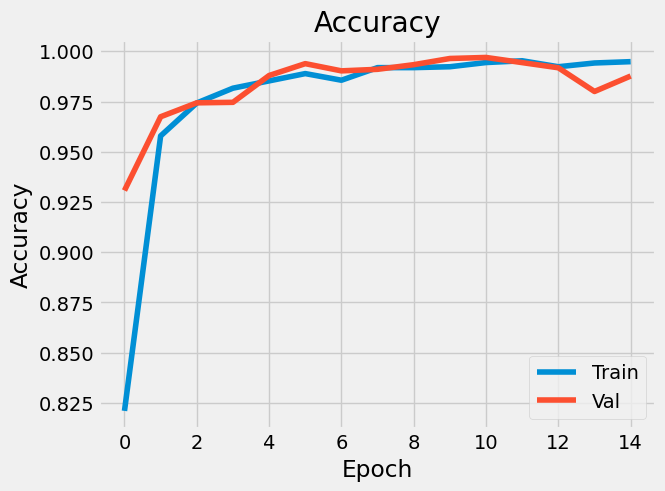

In [39]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

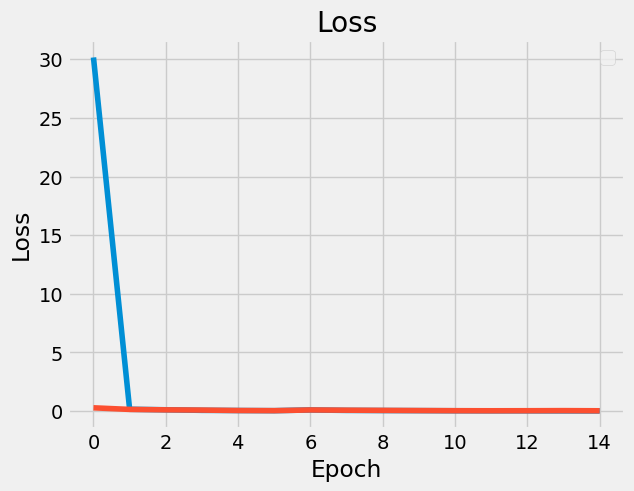

In [40]:
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [41]:
model.evaluate(X_train, y_train)[0]

285/285 [==============================] - 0s 350us/step - loss: 0.0295 - accuracy: 0.9859


0.029543643817305565